In [1]:
%pylab inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST

Populating the interactive namespace from numpy and matplotlib


## Data

* [Pytorch Transform Documentation](http://pytorch.org/docs/torchvision/transforms.html)


1. **torchvision.transforms.Compose:** 여러개의 tranforms을 실행합니다. 
2. **torchvision.transforms.ToTensor:** PIL.Image 또는 [0, 255] range의 Numpy array(H x W x C)를 (C x H x W)의 **[0.0, 1.0] range**를 갖은 torch.FloatTensor로 변형시킵니다. <br>여기서 포인트가 0에서 1사이의 값을 갖은 값으로 normalization이 포함되있습니다. 
3. **dataloader.DataLoader:** 사용하여 training시킬때 1개의 batch를 가져올때 shape이 **torch.Size([64, 1, 28, 28])** 이렇게 나옵니다. 

In [2]:
train = MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

test = MNIST('./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=1,num_workers=1, pin_memory=True)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

In [3]:
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - Transformed Shape:', train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

C:\Users\Shagesh\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - Transformed Shape: torch.Size([28, 60000, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


## Model

In [4]:
class Model(nn.Module):
    def __init__(self, n_inputs, n_neurons, Wx_in, Wy_in, Y_hat_in):
        super(Model, self).__init__()
        
        self.Wx = Wx_in # n_inputs X n_neurons
        self.Wy = Wy_in # n_neurons X n_neurons
        self.Y_hat = Y_hat_in # 1 x n_neurons
        
        self.Y0 = torch.randn(1, n_neurons) # 1 X n_neurons
        
        self.eta = 0.01 # learning rate
        self.ceiling = 100 # maximum activity
        self.input_size = n_inputs
        self.neuron_size = n_neurons
    
    def forward(self, X1):
#        self.Y0 = torch.ReLU(torch.mm(X0, self.Wx) + self.b) # batch_size X n_neurons
        
        self.Y0 = torch.mm(X1, self.Wx) - torch.mm(self.Y0, self.Wy) # batch_size X n_neurons, highest activity 100
        self.Y0[self.Y0 < 0] = 0
        return self.Y0
    
    def updateY(self, Y_in):
        self.Y0 = self.Y0 + self.eta*(Y_in - self.Y0)

    def updateY_hat(self, outputs):
        self.Y_hat += torch.mul(outputs, outputs)
#        self.Y_hat = torch.clamp(self.Y0, -10**10, 10**10)
        self.Y_hat[torch.isnan(self.Y_hat)] = 0
        
    def updateWy(self, outputs):
        D = torch.diag(torch.diag(self.Wy))
        self.Wy += torch.div(torch.mm(outputs.T, outputs) - torch.mul(self.Wy, torch.mm(torch.ones((self.neuron_size, 1)), torch.mul(outputs, outputs))), torch.mm(torch.ones((self.neuron_size, 1)), self.Y_hat) + 10**-30)
        self.Wy = self.Wy - torch.diag(torch.diag(self.Wy)) + D
        self.Wy[torch.isnan(self.Wy)] = 0
#        self.Wy = torch.clamp(self.Wy, -10**10, 10**10)

    def updateWx(self, outputs, inputs):
        self.Wx += torch.div(torch.mm(inputs.T, outputs) - torch.mul(self.Wx, torch.mm(torch.ones((self.input_size,1)), torch.mul(outputs, outputs))), torch.mm(torch.ones((self.input_size, 1)), self.Y_hat) + 10**-30)
        self.Wx[torch.isnan(self.Wx)] = 0
#        self.Wx = torch.clamp(self.Wx, -10**10, 10**10)

N_INPUT = 1*28*28 # number of features in input
N_NEURONS = 1000 # number of units in layer

N_INPUT_2 = 1000 # number of features in input
N_NEURONS_2 = 10 # number of units in layer

model = Model(N_INPUT, N_NEURONS, torch.randn(N_INPUT, N_NEURONS), torch.randn(N_NEURONS, N_NEURONS), torch.randn(1, N_NEURONS))
model_2 = Model(N_INPUT_2, N_NEURONS_2, torch.randn(N_INPUT_2, N_NEURONS_2), torch.randn(N_NEURONS_2, N_NEURONS_2), torch.randn(1, N_NEURONS_2))
criterion = torch.nn.MSELoss()
criterion_check = torch.nn.MSELoss()
model.cuda() # CUDA!
model_2.cuda() # CUDA!
#optimizer = optim.Adam(model.parameters(), lr=0.001)

Model()

## Train

In [5]:
model.train()

losses = []
for epoch in range(1):
    output_compare = torch.zeros(10, 10)
    for i, (inputs, labels) in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        model = Model(N_INPUT, N_NEURONS, model.Wx, model.Wy, model.Y_hat)
        model_2 = Model(N_INPUT_2, N_NEURONS_2, model_2.Wx, model_2.Wy, model_2.Y_hat)

        # forward + backward + optimize
        outputs = model.forward(inputs.flatten().view(-1, 1*28*28))
        loss = criterion(outputs, model.Y0)
        model.updateY(outputs)
        
        j = 0
        while(loss > 10**-5 and j < 10**5):
            outputs = model.forward(inputs.flatten().view(-1, 1*28*28))
            loss = criterion(outputs, model.Y0)
            model.updateY(outputs)
            j += 1
#        print(i, "loss:", loss)
        
        model.updateY_hat(outputs)
        model.updateWx(outputs, inputs.view(-1, 1 * 28 * 28))
        model.updateWy(outputs)        

        # forward + backward + optimize
        outputs_2 = model_2.forward(outputs)
        loss_2 = criterion(outputs_2, model_2.Y0)
        model_2.updateY(outputs_2)
        
        j = 0
        while(loss_2 > 10**-5 and j < 10**5):
            outputs_2 = model_2.forward(outputs)
            loss_2 = criterion(outputs_2, model_2.Y0)
            model_2.updateY(outputs_2)
            j += 1
#        print(i, "loss:", loss)
        
        model_2.updateY_hat(outputs_2)
        model_2.updateWx(outputs_2, outputs)
        model_2.updateWy(outputs_2)        
        
        loss_check = criterion_check(outputs_2, output_compare[labels])
        losses.append(loss_check)
        output_compare[labels] = outputs_2
        
        # Display
        if i % 100 == 1:
            print('\r Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, 
                i , 
                len(train_loader.dataset),
                100. * i / len(train_loader), 
                loss_check), 
                end='')
            
    print()

 Train Epoch: 0 [59901/60000 (100%)]	Loss: 26656.45507800


In [6]:
#output_compare
distance = torch.zeros(10)
for i, (inputs, labels) in enumerate(train_loader):
    model = Model(N_INPUT, N_NEURONS, model.Wx, model.Wy, model.Y_hat)
    model_2 = Model(N_INPUT_2, N_NEURONS_2, model_2.Wx, model_2.Wy, model_2.Y_hat)
    outputs = model.forward(inputs.flatten().view(-1, 1*28*28))
    j = 0
    while(loss > 10**-5 and j < 10**5):
        outputs = model.forward(inputs.flatten().view(-1, 1*28*28))
        loss = criterion(outputs, model.Y0)
        model.updateY(outputs)
        j += 1
    outputs_2 = model_2.forward(outputs)
    j = 0
    while(loss_2 > 10**-5 and j < 10**5):
        outputs_2 = model_2.forward(outputs)
        loss_2 = criterion(outputs_2, model_2.Y0)
        model_2.updateY(outputs_2)
        j += 1
    for j in range(10):
        distance[j] = torch.nn.functional.mse_loss(outputs_2[0], output_compare[j])
    print(outputs_2)
    print(np.argmin(distance.data.numpy()), '   ', labels)

tensor([[221.6072, 221.7424, 222.1394, 222.1719, 222.4467, 221.7653, 224.4931,
         224.3775, 223.6255, 223.1928]])
2     tensor([9])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
7     tensor([0])
tensor([[0.0000, 0.0000, 0.1521, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.8790,
         1.7717]])
7     tensor([1])
tensor([[43.1589, 42.8830, 41.2093, 41.7156, 41.1388, 41.0786, 44.2775, 41.1570,
         42.8238, 41.3574]])
1     tensor([6])
tensor([[1.6456, 1.5994, 1.6772, 1.4179, 1.2542, 1.5159, 0.0000, 1.2448, 0.8341,
         2.2525]])
0     tensor([9])
tensor([[1.2491, 1.5992, 1.8412, 0.8865, 1.4966, 0.7829, 0.5949, 0.0000, 1.4045,
         3.1828]])
0     tensor([4])
tensor([[1424.8674, 1427.2386, 1426.8217, 1425.3429, 1427.0277, 1422.2300,
         1420.1433, 1422.7875, 1428.4615, 1422.6000]])
5     tensor([3])
tensor([[0.0000, 0.4589, 0.8534, 0.3253, 0.3360, 0.3294, 0.0000, 0.0000, 0.8622,
         1.8979]])
7     tensor([3])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 

         0.0000]])
7     tensor([7])
tensor([[5.0990, 5.2388, 5.1247, 4.8903, 4.9789, 5.0296, 4.2915, 4.3948, 4.7422,
         3.1460]])
6     tensor([3])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
7     tensor([6])
tensor([[7.9316, 7.7728, 8.9726, 8.6474, 8.5664, 8.5868, 9.8405, 9.2016, 9.2566,
         3.3617]])
4     tensor([5])
tensor([[71.1683, 71.9123, 71.1090, 70.1822, 71.0387, 70.1512, 71.3030, 71.5923,
         71.0137, 67.9171]])
9     tensor([4])
tensor([[362.6220, 362.5824, 362.7049, 362.2761, 362.4847, 361.3652, 363.5195,
         361.5708, 361.9976, 356.0180]])
2     tensor([4])
tensor([[1.6014, 1.4142, 1.0804, 0.9606, 1.7729, 0.9383, 2.8868, 3.7496, 1.8824,
         0.0000]])
3     tensor([4])
tensor([[6.7364, 7.3624, 7.2877, 7.1747, 6.8145, 7.2716, 7.3332, 3.7082, 6.9789,
         3.8378]])
4     tensor([0])
tensor([[19.4709, 19.8655, 20.1500, 19.8423, 20.5601, 19.9899, 21.3207, 20.5367,
         19.9937, 19.6267]])
1     tensor([1])
tensor([[0., 0., 0., 0., 0.,

         1820.7280, 1820.3152, 1822.1149, 1806.5869]])
5     tensor([2])
tensor([[1401.5045, 1401.9192, 1402.3394, 1401.7227, 1402.0049, 1398.3060,
         1407.0684, 1401.5771, 1402.5692, 1394.8263]])
5     tensor([7])
tensor([[0.0000, 1.0721, 0.8365, 0.7678, 1.2987, 0.8179, 0.5689, 0.0000, 0.6628,
         0.5108]])
7     tensor([9])
tensor([[987.8229, 986.3875, 988.1763, 987.3658, 987.8166, 985.2380, 985.2549,
         987.4812, 988.4377, 982.0417]])
5     tensor([4])
tensor([[874.2518, 873.2039, 873.8794, 873.9159, 874.0626, 871.7438, 870.7660,
         872.5620, 874.1079, 869.9731]])
5     tensor([4])
tensor([[1255.1383, 1254.6953, 1255.4291, 1254.9259, 1255.4227, 1251.9083,
         1257.3771, 1256.2338, 1254.3297, 1247.5862]])
5     tensor([9])
tensor([[1.5275, 2.9605, 2.8004, 2.8150, 3.4331, 2.8107, 3.3332, 5.1526, 1.1344,
         5.6741]])
6     tensor([1])
tensor([[1206.6959, 1206.4099, 1206.9290, 1207.0623, 1207.7406, 1203.9515,
         1206.9921, 1205.8508, 1208.2191, 11

         0.0000]])
6     tensor([6])
tensor([[738.9628, 738.3132, 738.5605, 738.7712, 738.5796, 736.9965, 737.2213,
         739.8757, 739.2451, 730.0577]])
8     tensor([1])
tensor([[553.0925, 551.9789, 551.5605, 552.4125, 552.8386, 551.2154, 552.1231,
         550.8087, 551.7892, 550.6610]])
8     tensor([6])
tensor([[75.3707, 76.1577, 75.5128, 75.0257, 75.5722, 74.7951, 76.6834, 72.5819,
         75.1401, 79.2345]])
9     tensor([5])
tensor([[273.3433, 272.7137, 272.3227, 272.4117, 272.8703, 271.5127, 273.1174,
         272.6283, 272.5488, 273.7441]])
2     tensor([8])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
7     tensor([7])
tensor([[2.8926, 3.0569, 3.5289, 3.1177, 2.6907, 3.3340, 2.7575, 0.0000, 3.6979,
         3.0802]])
6     tensor([3])
tensor([[1.7927, 3.2153, 1.7133, 1.7113, 2.0231, 1.6600, 0.4020, 0.0000, 2.1785,
         3.6015]])
0     tensor([3])
tensor([[1282.2955, 1280.8984, 1280.1427, 1280.4174, 1280.0085, 1277.7178,
         1283.6862, 1280.6794, 1278.9620,

         10.5596, 14.2022]])
1     tensor([5])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
7     tensor([8])
tensor([[5.5615, 6.5718, 6.0631, 5.8449, 6.1381, 5.9980, 4.8591, 3.4557, 5.8495,
         3.6203]])
4     tensor([7])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
7     tensor([7])
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.3538, 0.2508, 0.0000,
         0.7076]])
3

KeyboardInterrupt: 

In [7]:
for i in range(10):
    print(output_compare[i])

tensor([1.1056, 1.4258, 1.0224, 0.6046, 0.9910, 0.4719, 0.6770, 2.5024, 0.1370,
        1.9324])
tensor([ 8.4415,  9.9785,  8.7024,  9.5090,  9.8807,  9.3170,  9.3587, 11.3190,
         9.2123, 12.4195])
tensor([138.4350, 139.5254, 139.6285, 139.8736, 139.5881, 139.2961, 139.9133,
        141.2150, 140.4979, 138.3175])
tensor([0.7357, 0.8298, 0.6720, 0.9445, 0.3645, 1.0492, 1.7568, 1.2148, 1.5874,
        0.0000])
tensor([4.6491, 5.2774, 5.9314, 5.7881, 5.7662, 5.3731, 8.3054, 4.5594, 5.6160,
        4.6641])
tensor([1051.2051, 1050.9301, 1051.2333, 1050.3193, 1050.9233, 1047.7910,
        1050.7106, 1048.4510, 1051.0040, 1041.0159])
tensor([4.8288, 4.9329, 5.5526, 4.4327, 4.5293, 4.4868, 1.4796, 3.5288, 3.2972,
        4.4954])
tensor([0.0000, 0.8325, 0.0000, 0.0000, 0.1031, 0.0000, 0.5006, 0.0000, 0.0000,
        0.8513])
tensor([628.5461, 627.4235, 627.2217, 627.2308, 627.9433, 625.0311, 627.4104,
        629.0347, 628.6405, 623.9290])
tensor([121.0107, 121.3654, 121.6761, 121.7563,

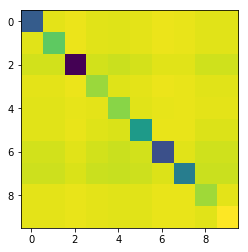

In [14]:
imshow(model_2.Wy)

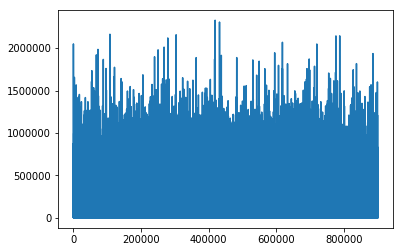

In [24]:
plot(losses)

## Evaluate

In [26]:
evaluate_x = Variable(test_loader.dataset.test_data.type_as(torch.FloatTensor())).cuda()
evaluate_y = Variable(test_loader.dataset.test_labels).cuda()


output = model(evaluate_x)
pred = output.data.max(1)[1]
d = pred.eq(evaluate_y.data).cpu().float()
accuracy = d.sum()/d.size()[0]

print('Accuracy:', accuracy)

RuntimeError: matrices expected, got 3D, 2D tensors at C:\w\1\s\tmp_conda_3.7_055457\conda\conda-bld\pytorch_1565416617654\work\aten\src\TH/generic/THTensorMath.cpp:747